In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation


In [69]:
train = pd.read_csv('Train_Data.csv')
test = pd.read_csv('Test_Data.csv')
sample_submission = pd.read_csv('Sample_Submission.csv')

In [70]:
train.drop(columns=['SEQN'], inplace=True)
test_ids = test['SEQN']
test.drop(columns=['SEQN'], inplace=True)


In [71]:
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
cat_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']

# Fill categorical NaNs with mode
train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])
test[cat_cols] = test[cat_cols].fillna(train[cat_cols].mode().iloc[0])

# Fill numeric NaNs with median
train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols] = test[num_cols].fillna(train[num_cols].median())

In [72]:
train['IN_GLU_RATIO'] = train['LBXIN'] / (train['LBXGLU'] + 1)
test['IN_GLU_RATIO'] = test['LBXIN'] / (test['LBXGLU'] + 1)

train['BMI_CAT'] = pd.cut(train['BMXBMI'], bins=[0,18.5,24.9,29.9,100], labels=[0,1,2,3]).astype(int)
test['BMI_CAT'] = pd.cut(test['BMXBMI'], bins=[0,18.5,24.9,29.9,100], labels=[0,1,2,3]).astype(int)


In [73]:
# Safely extract and clean target
y = train['age_group'].map({'Adult': 0, 'Senior': 1})
X = train.drop(columns=['age_group'])

# Remove any rows where target couldn't be mapped
X = X[~y.isna()]
y = y[~y.isna()].astype(int)


# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
test = test.apply(pd.to_numeric, errors='coerce')

# Fill any NaNs (just in case)
X.fillna(0, inplace=True)
test.fillna(0, inplace=True)


🚀 Fold 1
[LightGBM] [Info] Number of positive: 251, number of negative: 1310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160794 -> initscore=-1.652329
[LightGBM] [Info] Start training from score -1.652329
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 

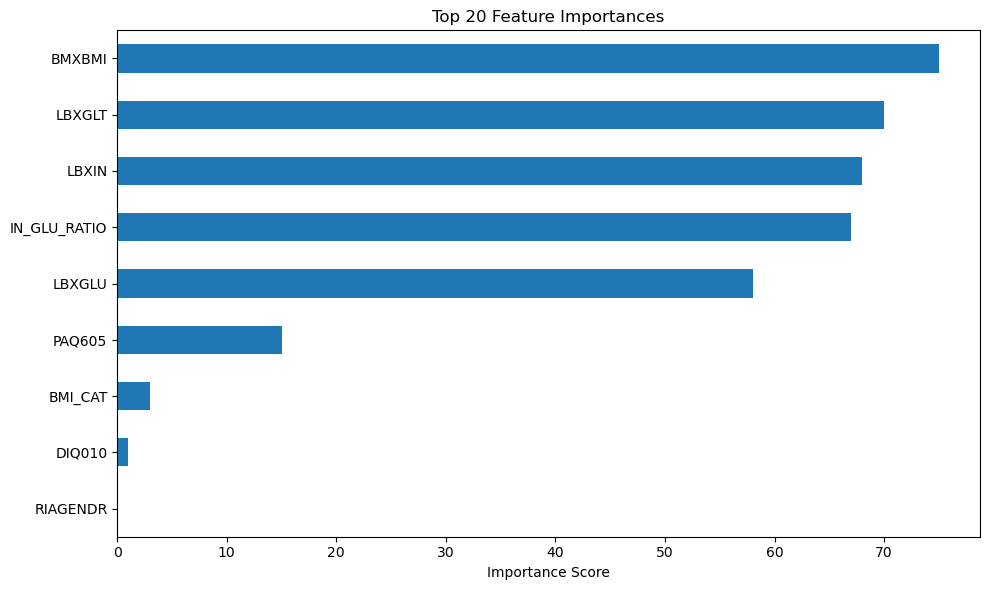

In [74]:


# Prepare data (assuming X, y, test already cleaned and preprocessed)

f1_scores = []
final_preds = np.zeros(len(test))
thresholds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🚀 Fold {fold + 1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute scale_pos_weight (to balance classes)
    pos_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

    model = LGBMClassifier(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=pos_ratio,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=10,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss',
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(50)
        ]
    )

    val_probs = model.predict_proba(X_val)[:, 1]

    # Tune threshold on validation set
    best_th, best_f1 = 0.5, 0
    for t in np.arange(0.2, 0.8, 0.01):
        preds = (val_probs > t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_th = t

    print(f"✅ Fold {fold + 1} Best Threshold: {round(best_th, 2)}, Best F1: {round(best_f1, 4)}")
    f1_scores.append(best_f1)
    thresholds.append(best_th)

    # Predict on test and average
    final_preds += model.predict_proba(test)[:, 1] / skf.n_splits

# Final evaluation
avg_f1 = np.mean(f1_scores)
avg_threshold = np.mean(thresholds)
print(f"\n📊 Average F1 Score across folds: {round(avg_f1, 4)}")
print(f"📌 Average Optimal Threshold: {round(avg_threshold, 3)}")

# Final test predictions
submission_preds = (final_preds > avg_threshold).astype(int)

# Save submission
submission = pd.DataFrame({'age_group': submission_preds})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv file created!")

# Plot Feature Importance
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
feat_names = X.columns
imp_df = pd.Series(importances, index=feat_names).sort_values(ascending=True)
imp_df.tail(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
